# Synthetic Electronic Health Record Data (SEHRD) package demo
This notebook demonstrates SEHRD package functionality on a toy dataset.

## Setup

### Import python and SEHRD modules

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split

from preprocessor import preprocessor
from corgan import corgan
from realism import realism
from privacy import privacy

### Set parameters for the toy dataset and demo

In [2]:
# toy dataset
n = 1000
count_min = 5
count_max = 19
constant_value = 'helloworld'
binary_A = 'A'
binary_B = 'B'
categorical_values = ['X','Y','Z']

# synthetic data generation and validation
n_gen = n
outcome = 'binary01'

# sehrd objects
pre = preprocessor(missing_value=-99999)
rea = realism(missing_value=-99999)
pri = privacy()
cor = corgan()

### Generate the toy dataset

In [3]:
names = ['constant','binary01', 'binaryAB', 'categorical','count','continuous']
v_constant = np.full(shape=n, fill_value=constant_value)
v_binary01 = np.random.randint(low=0, high=2, size=n)
v_binaryAB = np.concatenate((np.full(shape=n-1, fill_value=binary_A), np.array([binary_B])))
v_categorical = np.random.choice(categorical_values, size=n)
v_count = np.random.randint(low=count_min, high=count_max+1, size=n)
v_continuous = np.random.random(size=n)
x = np.column_stack((v_constant, v_binary01, v_binaryAB, v_categorical, v_count, v_continuous))
print(x)

[['helloworld' '1' 'A' 'Z' '11' '0.03148805764072893']
 ['helloworld' '0' 'A' 'Z' '11' '0.4779227115913218']
 ['helloworld' '0' 'A' 'Y' '5' '0.042181201983812366']
 ...
 ['helloworld' '0' 'A' 'Z' '9' '0.2823859399953834']
 ['helloworld' '0' 'A' 'X' '15' '0.813188649649376']
 ['helloworld' '0' 'B' 'Z' '11' '0.9646566152865818']]


## Preprocessing

### Save metadata for restoring data format after synthetic data generation

In [4]:
m = pre.get_metadata(x=x, header=names)
print('var_name, var_type, min, max, zero, one')
print(m)

var_name, var_type, min, max, zero, one
[('constant', 'constant', 0.00000000e+00,  0.        , 'helloworld', '')
 ('binary01', 'binary', 0.00000000e+00,  0.        , '0', '1')
 ('binaryAB', 'binary', 0.00000000e+00,  0.        , 'A', 'B')
 ('categorical', 'categorical', 0.00000000e+00,  0.        , '', '')
 ('count', 'count', 5.00000000e+00, 19.        , '', '')
 ('continuous', 'continuous', 8.53870666e-04,  0.99821322, '', '')]


### Encode raw data matrix in preparation for training synthetic data generator
Note that count and continuous variables have been scaled between 0 and 1 while constant, categorical, and binary have been one-hot encoded.

In [5]:
d = pre.get_discretized_matrix(x, m, names)
print('Formatted matrix:')
print(d['x'])
print('\nHeader for formatted matrix:')
print(d['header'])

Formatted matrix:
[[0.         1.         0.         ... 1.         0.42857143 0.0307153 ]
 [0.         0.         0.         ... 1.         0.42857143 0.47833195]
 [0.         0.         0.         ... 0.         0.         0.04143675]
 ...
 [0.         0.         0.         ... 1.         0.28571429 0.28227747]
 [0.         0.         0.         ... 0.         0.71428571 0.81448555]
 [0.         0.         1.         ... 1.         0.42857143 0.96635455]]

Header for formatted matrix:
['constant' 'binary01' 'binaryAB' 'categorical__X' 'categorical__Y'
 'categorical__Z' 'count' 'continuous']


## Generation

### Train CorGAN model 

In [6]:
model = cor.train(x=d['x'], n_cpu=15)

### Generate synthetic samples

In [7]:
s = cor.generate(model, n_gen)
print(s)

[[7.38135306e-03 7.40758121e-01 1.84497274e-02 ... 1.74200296e-01
  1.02218561e-01 9.92099822e-01]
 [6.80302875e-03 3.42431333e-04 3.26626077e-02 ... 4.93904531e-01
  9.66996670e-01 5.89354895e-03]
 [9.87000018e-03 6.39108419e-01 3.28268707e-02 ... 2.33602226e-02
  9.99239683e-01 9.98847723e-01]
 ...
 [2.43831193e-03 5.66772044e-01 6.68885792e-03 ... 7.48093486e-01
  1.30080190e-02 8.22147548e-01]
 [7.57393567e-03 9.41256225e-01 2.04878896e-02 ... 5.97040594e-01
  9.92925763e-01 6.39811754e-01]
 [3.73096508e-03 9.94164288e-01 1.50175905e-02 ... 9.78583455e-01
  3.27437937e-01 9.98740256e-01]]


### Use metadata to restore original formatting

In [8]:
f = pre.restore_matrix(s=s, m=m, header=d['header'])
print('Synthetic samples:')
print(f['x'])
print('\nReal samples:')
print(x)

Synthetic samples:
[['helloworld' '0' 'A' 'X' '6.0' '0.9903339024780393']
 ['helloworld' '0' 'A' 'Z' '19.0' '0.006731856808092893']
 ['helloworld' '0' 'A' 'X' '19.0' '0.9970639850625101']
 ...
 ['helloworld' '0' 'A' 'Z' '5.0' '0.82083041381308']
 ['helloworld' '0' 'A' 'Z' '19.0' '0.6389761051056139']
 ['helloworld' '0' 'A' 'Z' '10.0' '0.996956801671322']]

Real samples:
[['helloworld' '1' 'A' 'Z' '11' '0.03148805764072893']
 ['helloworld' '0' 'A' 'Z' '11' '0.4779227115913218']
 ['helloworld' '0' 'A' 'Y' '5' '0.042181201983812366']
 ...
 ['helloworld' '0' 'A' 'Z' '9' '0.2823859399953834']
 ['helloworld' '0' 'A' 'X' '15' '0.813188649649376']
 ['helloworld' '0' 'B' 'Z' '11' '0.9646566152865818']]


## Realism

### Compare univariate frequency for real and synthetic features

In [9]:
res_uni = rea.validate_univariate(r=d['x'], s=s, header=d['header'], discretized=True)
corr_uni = np.corrcoef(x=res_uni['frq_r'], y=res_uni['frq_s'])[0,1]
print('Correlation between feature frequencies =',np.round(corr_uni,2))

Correlation between feature frequencies = 0.87


Plot the synthetic and real feature frequencies for each feature...

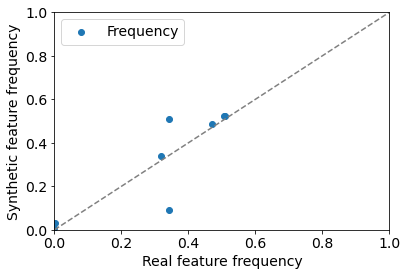

In [10]:
fontsize = 14
fig, ax1 = plt.subplots(1,1)
ax1.plot([0,1],[0,1], color="gray", linestyle='--')
ax1.scatter(res_uni['frq_r'], res_uni['frq_s'], label='Frequency')
ax1.set_xlabel('Real feature frequency', fontsize=fontsize)
ax1.set_ylabel('Synthetic feature frequency', fontsize=fontsize)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.tick_params(axis='x', labelsize=fontsize)
ax1.tick_params(axis='y', labelsize=fontsize)
ax1.legend(fontsize=fontsize)

### Compare predictive performance
* Real: use real dataset to train predictive model and test on a separate real dataset
* GAN-train: use synthetic dataset to train predictive model and test on a real dataset
*GAN-test: use real dataset to train predictive model and test on the synthetic dataset

In [11]:
print('Extract outcome \'', outcome,'\' from real and synthetic datasets', sep='')

Extract outcome 'binary01' from real and synthetic datasets


In [12]:
r = d['x']

idx_outcome = np.where(d['header'] == outcome)
y_r = np.reshape(np.round(np.reshape(r[:,idx_outcome], newshape=(len(r),1))).astype(int), len(r))
y_s = np.reshape(np.round(np.reshape(s[:,idx_outcome], newshape=(len(s),1))).astype(int), len(s))
x_r = np.delete(r, idx_outcome, axis=1)
x_s = np.delete(s, idx_outcome, axis=1)

print('Real dataset dimensions:',x_r.shape)
print('Synthetic dataset dimensions:',x_s.shape)

Real dataset dimensions: (1000, 7)
Synthetic dataset dimensions: (1000, 7)


Train model for each validation test

In [13]:
n_epoch = 20
model_type='lr'

res_gan_real = rea.gan_train(x_r, y_r, x_r, y_r, n_epoch=n_epoch, model_type=model_type)
res_gan_train = rea.gan_train(x_s, y_s, x_r, y_r, n_epoch=n_epoch, model_type=model_type)
res_gan_test = rea.gan_test(x_s, y_s, x_r, y_r, n_epoch=n_epoch, model_type=model_type)

Plot resulting ROC curves

Text(0, 0.5, 'True positive rate')

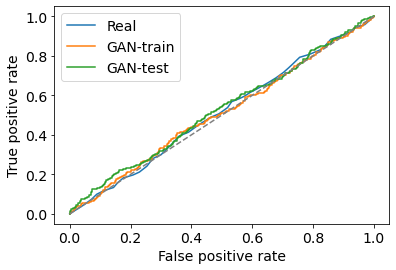

In [14]:
fontsize = 14
fig, ax3 = plt.subplots(1,1)
ax3.plot(res_gan_real['roc'][0], res_gan_real['roc'][1], label="Real")
ax3.plot(res_gan_train['roc'][0], res_gan_train['roc'][1], label="GAN-train")
ax3.plot(res_gan_test['roc'][0], res_gan_test['roc'][1], label="GAN-test")
ax3.plot([0,1],[0,1], color="gray", linestyle='--')
ax3.tick_params(axis='x', labelsize=fontsize)
ax3.tick_params(axis='y', labelsize=fontsize)
ax3.legend(fontsize=fontsize)
ax3.set_xlabel('False positive rate', fontsize=fontsize)
ax3.set_ylabel('True positive rate', fontsize=fontsize)

## Privacy

## Nearest neighbors
Ensure that synthetic dataset is not a copy of the real dataset by comparing distances between pairs of real and synthetic samples
* Real-real: distance between randomly selected pairs of real samples
* Real-synthetic: distance between pairs of real and synthetic samples
* Real-probabilistic: distance between a real sample and sampled binary vector where each column is sampled from a binomial where the frequency equals that in the real training set
* Real-random: distance between a real sample and a randomly sampled binary vector

In [15]:
n_nn_sample = 100
dist_metric = 'euclidean'
n_decimal=2

idx_r = np.random.randint(low=0, high=len(r), size=min((len(r), n_nn_sample)))
idx_s = np.random.randint(low=0, high=len(s), size=min((len(s), n_nn_sample)))
res_nn = pri.assess_memorization(r[idx_r,:], s[idx_s,:], metric=dist_metric)

print('Mean nearest neighbor distance: ')
print('  > Real-real:\t\t'+str(np.round(np.mean(res_nn['real']),n_decimal)))
print('  > Real-synthetic:\t'+str(np.round(np.mean(res_nn['synth']),n_decimal)))
print('  > Real-probabilistic: '+str(np.round(np.mean(res_nn['prob']),n_decimal)))
print('  > Real-random:\t'+str(np.round(np.mean(res_nn['rand']),n_decimal)))

Mean nearest neighbor distance: 
  > Real-real:		0.12
  > Real-synthetic:	0.55
  > Real-probabilistic: 0.43
  > Real-random:	0.84


Plot distributions for nearest neighbor distances

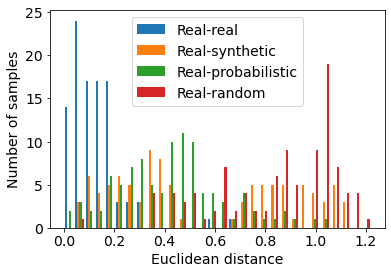

In [16]:
fontsize = 14
fig, ax2 = plt.subplots(1,1)
ax2.hist((res_nn['real'], res_nn['synth'], 
          res_nn['prob'], res_nn['rand']),
         bins=30, 
         label = ['Real-real','Real-synthetic','Real-probabilistic','Real-random'])
ax2.set_xlabel(dist_metric.capitalize()+' distance', fontsize=fontsize)
ax2.set_ylabel('Number of samples', fontsize=fontsize)
ax2.tick_params(axis='x', labelsize=fontsize)
ax2.tick_params(axis='y', labelsize=fontsize)
ax2.legend(fontsize=fontsize)


## Membership inference
Membership inference is a well researched area for determining the privacy preserving properties of machine learning models. Membership inference is defined as the ability to infer if a given sample was included in the training set of a model.  

In the case of generative models and synthetic data, we use the membership inference paradigm to quantify risks to the privacy of participants whose data was used to train the generator.  We assume a black-box model with respect to the generator and that the attacker has access to data from same sample population as the real training data.  

The attack model is a binary classifier trained on a combination of synthetic data output from the generator ('out') and a real auxiliary dataset that was not used to train the generator ('in') to serve as a proxy the real training data.  We then test the ability of the trained classifier to distinguish synthetic from auxiliary data samples.  Finally, we infer the risk of membership inference by using the same classifier to distinguish between real data samples used to train the generator ('in') and real data samples held out from the generator's training set ('out').  

In [22]:
# split real-generator, real-auxilliary
n_subset_d = round(len(d['x'])*0.5)
r, a = random_split(d['x'], [n_subset_d, len(d['x']) - n_subset_d])
n_subset_r = round(len(r)*0.75)
n_subset_a = round(len(a)*0.75)
r_trn, r_tst = random_split(r, [n_subset_r,len(r)-n_subset_r])
a_trn, a_tst = random_split(a, [n_subset_a,len(a)-n_subset_a])
r_trn = np.array(r_trn)
r_tst = np.array(r_tst)
a_trn = np.array(a_trn)
a_tst = np.array(a_tst)

# generate synthetic data and split
model = cor.train(x=r_trn, n_cpu=16, debug=False, n_epochs=100)
s = cor.generate(model, n_gen=len(r_tst))
n_subset_s = round(len(s)*0.75)
s_trn, s_tst = random_split(s, [n_subset_s, len(s)-n_subset_s])
s_trn = np.array(s_trn)
s_tst = np.array(s_tst)

# infer performance of the attack model
mem_inf = pri.membership_inference(r_trn=r_trn, r_tst=r_tst, s_trn=s_trn, s_tst=s_tst,
            a_trn=a_trn, a_tst=a_tst, model_type='svm')


In [23]:
# print area-under the curve
print('AUC for auxiliary-synthetic: ', mem_inf['auc_as'])
print('AUC for real train-test: ', mem_inf['auc_rr'])


AUC for auxiliary-synthetic:  1.0
AUC for real train-test:  0.5199146666666666
